In [181]:
# import numpy, pandas, matplotlib, seaborn, sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#  import Exp1B.csv
dm_image = pd.read_csv('Exp1B.csv')



In [182]:
# selecting choice trials and preprocessing data
from sklearn.preprocessing import scale

# select choice trials and preprocess data
choice = dm_image.loc[dm_image['ttype'] == 'choice_task']
choice = choice.loc[choice['rt'] != "null"].copy()
choice['rt'] = pd.to_numeric(choice['rt'])
choice['delta.value'] = pd.to_numeric(choice['value_right']) - pd.to_numeric(choice['value_left'])
choice['delta.mem'] = pd.to_numeric(choice['mem_right']) - pd.to_numeric(choice['mem_left'])
choice['choseright'] = np.where(choice['key_press'] == 75, 1, np.where(choice['key_press'] == 74, 0, np.nan))
choice['abs.mem'] = np.abs(choice['delta.mem'])
choice['chosehigh.mem'] = np.where(
    (choice['choseright'] == 1) & (choice['delta.mem'] >= 0), # condition 1
    1, # value to assign if condition 1 is True
    np.where(
        (choice['choseright'] == 0) & (choice['delta.mem'] < 0), # condition 2
        1, # value to assign if condition 2 is True
        np.where(
            (choice['choseright'] == 1) & (choice['delta.mem'] < 0), # condition 3
            0, # value to assign if condition 3 is True
            0 # value to assign if all conditions are False
        )
    )
)
choice = choice.groupby('ID').apply(lambda x: x.assign(z_delta_value = scale(x['delta.value'])))

choice = choice.loc[choice['rt'] >= 300]

# print choice
print(choice)

       Unnamed: 0  run_id        rt responses        ttype  \
426           427       5  1093.590         "  choice_task   
429           430       5  1082.210         "  choice_task   
432           433       5  1323.715         "  choice_task   
435           436       5   934.940         "  choice_task   
438           439       5  1123.285         "  choice_task   
...           ...     ...       ...       ...          ...   
37045       37046      13  1369.315         "  choice_task   
37048       37049      13   938.240         "  choice_task   
37051       37052      13   750.710         "  choice_task   
37054       37055      13   937.355         "  choice_task   
37057       37058      13  1416.395         "  choice_task   

                   trial_type  trial_index  time_elapsed  internal_node_id  \
426    html-keyboard-response          426       1238099      0.0-16.0-0.0   
429    html-keyboard-response          429       1242109      0.0-16.1-0.1   
432    html-keyboard-

/tmp/ipykernel_15881/1150727569.py:25: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  choice = choice.groupby('ID').apply(lambda x: x.assign(z_delta_value = scale(x['delta.value'])))


0.0007221489090216693
[0.5499242882144232, 0.3990564477360611, 0.4131358165067533, 0.42647159282046243, 0.37358017199174515, 0.5191753455173678, 1.8229711347088493, 1.2331883390488028, 0.698609863942699, 1.0794192020215116, 0.4365245093247499, 0.45758449620461994, 1.575300150806319, 0.7907243519248889, 0.8525768132162722, 0.49653806764908126, 1.5977416491098628, 0.6266080448653715, 0.28369206288434345, 0.34107538815120836, 0.28205293523248903, 0.3509481711146066, 0.29348230083033394, 0.3333683251328717, 0.4248049446702242, 0.3068812243479113, 0.27289101252589953, 0.21456155109509972, 0.22286592685698411, 0.3042582967301832, 0.25151358707375526, 0.42722734973364834, 0.28887001658273503, 0.3061033343521307, 0.35993489290887865, 0.342090435579579, 0.37205815400654313, 0.22063528799821935, 0.34432800493634924, 0.374659709639096, 0.35604868392334926, 0.352562304656192, 0.5297021098497882, 0.38897316497223233, 0.37336702385592513, 0.3166576432088302, 0.3142482646030815, 0.3617556547363722, 0

<ErrorbarContainer object of 3 artists>

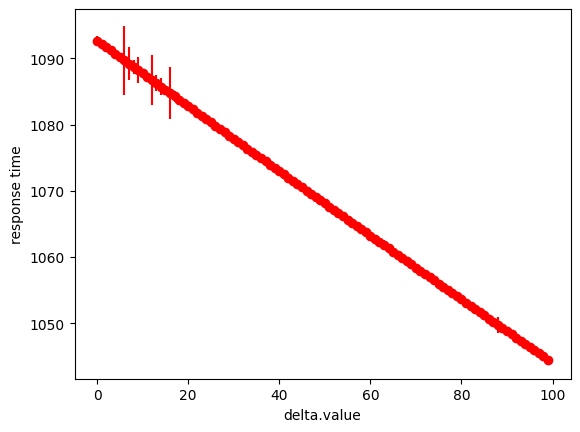

In [183]:
rating = dm_image.loc[dm_image['ttype'] == 'choice_task']

# only consider value_left and value_right and response time columns
rating = rating[['ID', 'value_left', 'value_right', 'rt', 'key_press']]

# add another column with the difference between value_left and value_right
rating['delta.value'] = abs(pd.to_numeric(rating['value_right']) - pd.to_numeric(rating['value_left']))

# fill average response time for missing values
rating['rt'] = rating['rt'].fillna(rating['rt'].mean())

# logistic transormation on delta.value
# rating['delta.value'] = np.log(rating['delta.value']+1)


# only consider delta.value < 10
rating = rating.loc[rating['delta.value'] < 100]

# logistic transormation on rt
rating['rt'] = np.log(rating['rt']+1)

# linear regression
from sklearn.linear_model import LinearRegression

# create linear regression object
regr = LinearRegression()

# fit linear regression model
regr.fit(rating[['delta.value']], rating['rt'])
# predict response time
rating['rt_pred'] = regr.predict(rating[['delta.value']])
# print score
print(regr.score(rating[['delta.value']], rating['rt']))


# include confidence interval for 95% confidence level
from statsmodels.stats.outliers_influence import summary_table

error = []
rt_pred = []
for i in range(0,100):
    # select rows with delta.value = i
    rating_i = rating.loc[rating['delta.value'] == i]
    rt_pred.append(rating_i['rt_pred'].mean())
    # root mean square error
    error.append(np.sqrt(np.sum(np.square(rating_i['rt'] - rating_i['rt_pred']))/len(rating_i))) 

print(error)

# reverse logistic transformation on error and rt_pred
error = np.exp(error) - 1
rt_pred = np.exp(rt_pred) - 1



# x axis is 0 to 10
x = np.arange(0,100,1)
# plot response time and predicted response time
# add labels
plt.xlabel('delta.value')
plt.ylabel('response time')

plt.plot(x, rt_pred, color='red', label='predicted response time')
# plot error bars
plt.errorbar(x, rt_pred, yerr=error, fmt='o', color='red', label='error')


                        ID  delta.mem  chosehigh.mem
delta.mem.group                                     
0                27.480328   0.011719       0.511475
1                28.479475   0.033875       0.453202
2                30.684976   0.057372       0.520194
3                28.922428   0.079578       0.541315
4                27.618182   0.103835       0.451240
5                27.511513   0.131969       0.473684
6                30.026359   0.164488       0.495881
7                29.336634   0.202009       0.457096
8                28.595745   0.255397       0.484452
9                29.274834   0.382523       0.465232
0.12789938453249017


/tmp/ipykernel_15881/1818465666.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rating = rating.groupby('delta.mem.group').mean()


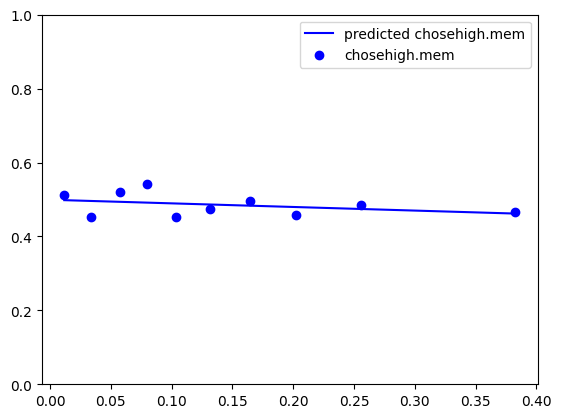

In [184]:
rating = dm_image.loc[dm_image['ttype'] == 'choice_task']
# only consider the columns mem_left, mem_right, and key_press
rating = rating[['ID', 'mem_left', 'mem_right', 'key_press']]
# add another column with the difference between mem_left and mem_right
rating['delta.mem'] = abs(pd.to_numeric(rating['mem_right']) - pd.to_numeric(rating['mem_left']))

# add another column , mark as 1 if chosen the more memorable image, 0 otherwise
rating['chosehigh.mem'] = np.where(
    (rating['key_press'] == "75") & (rating['mem_right'] >= rating['mem_left']), # condition 1
    1, # value to assign if condition 1 is True
    np.where(
        (rating['key_press'] == "74") & (rating['mem_left'] < rating['mem_right']), # condition 2
        1, # value to assign if condition 2 is True
        np.where(
            (rating['key_press'] == "75") & (rating['mem_right']< rating['mem_left']), # condition 3
            0, # value to assign if condition 3 is True
            0 # value to assign if all conditions are False
        )
    )
)


# sort by delta.mem
rating = rating.sort_values(by=['delta.mem'])

# divide into 5 equal groups in ascending order
rating['delta.mem.group'] = pd.qcut(rating['delta.mem'], 10, labels=False)


# find mean chosehigh.mem and delta.mem for each group
rating = rating.groupby('delta.mem.group').mean()
print(rating)


# linear regression
from sklearn.linear_model import LinearRegression

# create linear regression object
regr = LinearRegression()

# fit linear regression model
regr.fit(rating[['delta.mem']], rating['chosehigh.mem'])
# predict chosehigh.mem
rating['chosehigh.mem_pred'] = regr.predict(rating[['delta.mem']])
# print score
print(regr.score(rating[['delta.mem']], rating['chosehigh.mem']))

#  plot the linear regression model
plt.plot(rating['delta.mem'], rating['chosehigh.mem_pred'], color='blue', label='predicted chosehigh.mem')
plt.scatter(rating['delta.mem'], rating['chosehigh.mem'], color='blue', label='chosehigh.mem')
#  y axis is 0 to 1
plt.ylim(0,1)
# label the axes
plt.xlabel('delta.mem')
plt.ylabel('chosehigh.mem')

plt.legend()
plt.show()






In [185]:
# sort data by delta.value
curr_rating = rating.sort_values(by=['delta.value'])

# only consider the data with delta.value < 4
curr_rating = curr_rating.loc[curr_rating['delta.value'] <6]


# divide data into 5 groups sequentially without using qcut
# do not use qcut because it will divide data into 5 groups with equal number of observations
# curr_rating['group'] = pd.qcut(curr_rating['delta.value'], 5, labels=False)

# set group for all records as 0
curr_rating['group'] = 0

# make two buckets for delta from 0 to 1 and divide randomly

# select records with delta.value between 0 and 1, two 
curr_rating_0_1 = curr_rating.loc[(curr_rating['delta.value'] >= 0) & (curr_rating['delta.value'] < 2)]

# randomly divide records into two groups
curr_rating_0_1['group'] = np.random.choice([0, 1], len(curr_rating_0_1), p=[0.5, 0.5])

#  two buckets for delta from 1 to 2 and divide randomly

# select records with delta.value between 1 and 2
curr_rating_1_2 = curr_rating.loc[(curr_rating['delta.value'] >= 1) & (curr_rating['delta.value'] < 3)]

# randomly divide records into two groups
curr_rating_1_2['group'] = np.random.choice([0, 1], len(curr_rating_1_2), p=[0.5, 0.5])

#  one bucker for delta from 2 to 3 and 
# select records with delta.value between 2 and 3
curr_rating_2_3 = curr_rating.loc[(curr_rating['delta.value'] >= 2) & (curr_rating['delta.value'] < 4)]

# randomly divide records into one group
curr_rating_2_3['group'] = np.random.choice([0], len(curr_rating_2_3), p=[1])

mean_delta= [] 
mean_rt = []

# calculate mean delta.value and mean rt for each group
for i in range(0, 2):
    mean_delta.append(curr_rating_0_1.loc[curr_rating_0_1['group'] == i]['delta.value'].mean())
    mean_rt.append(curr_rating_0_1.loc[curr_rating_0_1['group'] == i]['rt'].mean())

for i in range(0, 2):
    mean_delta.append(curr_rating_1_2.loc[curr_rating_1_2['group'] == i]['delta.value'].mean())
    mean_rt.append(curr_rating_1_2.loc[curr_rating_1_2['group'] == i]['rt'].mean())

for i in range(0, 1):
    mean_delta.append(curr_rating_2_3.loc[curr_rating_2_3['group'] == i]['delta.value'].mean())
    mean_rt.append(curr_rating_2_3.loc[curr_rating_2_3['group'] == i]['rt'].mean())


# plot mean response time for each group
plt.scatter(mean_delta, mean_rt, color='blue')
plt.plot(mean_delta, mean_rt, color='red')
plt.xlabel('delta.value')
plt.ylabel('rt')
plt.show()





# print curr_rating
print(curr_rating)

# calculate mean response time for each group
curr_rating = curr_rating.groupby('group').mean()
print(curr_rating)
# plot mean response time for each group
plt.scatter(curr_rating['delta.value'], curr_rating['rt'], color='blue')
plt.plot(curr_rating['delta.value'], curr_rating['rt'], color='red')
plt.xlabel('delta.value')
plt.ylabel('rt')
plt.show()




KeyError: 'delta.value'

       Unnamed: 0  run_id        rt responses        ttype  \
426           427       5  1093.590         "  choice_task   
429           430       5  1082.210         "  choice_task   
432           433       5  1323.715         "  choice_task   
435           436       5   934.940         "  choice_task   
438           439       5  1123.285         "  choice_task   
...           ...     ...       ...       ...          ...   
37045       37046      13  1369.315         "  choice_task   
37048       37049      13   938.240         "  choice_task   
37051       37052      13   750.710         "  choice_task   
37054       37055      13   937.355         "  choice_task   
37057       37058      13  1416.395         "  choice_task   

                   trial_type  trial_index  time_elapsed  internal_node_id  \
426    html-keyboard-response          426       1238099      0.0-16.0-0.0   
429    html-keyboard-response          429       1242109      0.0-16.1-0.1   
432    html-keyboard-

/tmp/ipykernel_15881/3028871318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['delta.value'] = abs(pd.to_numeric(rating['value_right']) - pd.to_numeric(rating['value_left']))
/tmp/ipykernel_15881/3028871318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['choseleft'] = np.where(rating['key_press'] == "74", 1, np.where(rating['key_press'] == "75", 0, np.nan))


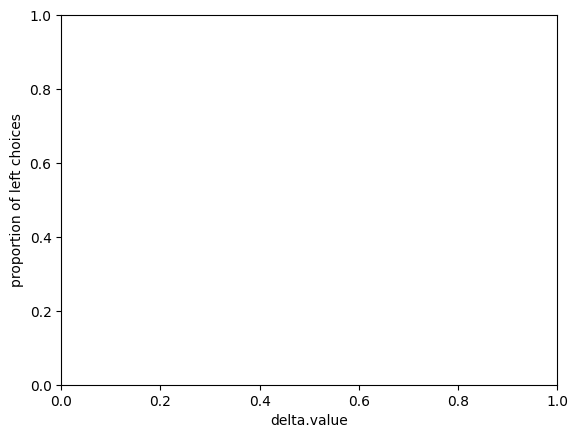

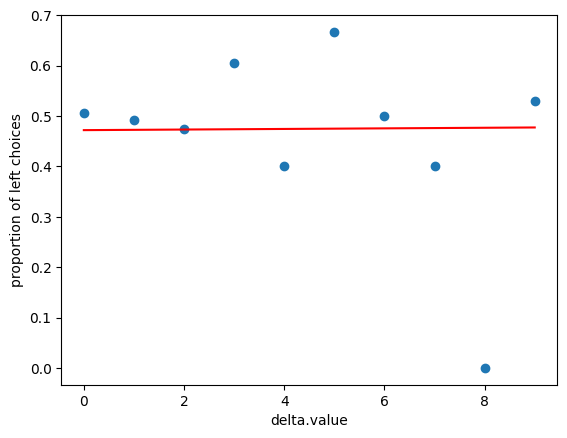

In [194]:
# add columns choseleft when key_press is 74 and choseright when key_press is 75
rating = dm_image.loc[dm_image['ttype'] == 'choice_task']
rating['delta.value'] = abs(pd.to_numeric(rating['value_right']) - pd.to_numeric(rating['value_left']))
print(rating)
rating['choseleft'] = np.where(rating['key_press'] == "74", 1, np.where(rating['key_press'] == "75", 0, np.nan))

print(rating)

# for different delta values, calculate the proportion of choices for the left option
left = []
for i in range(0, 60):
    # for delta value of i , calculate left/left+right

    # select rows with delta value of i
    rating_i = rating.loc[rating['delta.value'] == i]
    # find num left
    num_left = rating_i['choseleft'].sum()
    # find num right
    num_right = rating_i['choseleft'].count() - num_left

    # calculate proportion of left
    if num_left + num_right == 0:
        left.append(0)
    else:
        left.append(num_left / (num_left + num_right))

# linear regression for probability of left choice
# create linear regression object
regr = LinearRegression()

# fit linear regression model x is range of delta values ( 0 to 60) and y is proportion of left choices
#  form numpy array 0 to 60

# slice first 10 elements of left


# plot proportion of left choices for different delta values
# plt.plot(range(0, 10), left)
plt.xlabel('delta.value')
plt.ylabel('proportion of left choices')
plt.show()



import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

x = np.arange(0, 60)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, left)
left = left[0:10]
x = x[0:10]
plt.scatter(x, left)
# lable 
plt.xlabel('delta.value')
plt.ylabel('proportion of left choices')
plt.plot(x, slope*x + intercept, color='red')
plt.show()

